In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Union, Tuple

import logging
import pandas as pd
from pathlib import Path

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import xarray
from tqdm import tqdm

#### required aibedo(temporal) libs

In [2]:
from aibedo.Config import Config
import aibedo.rainfall_datautils as datautils
from aibedo.models import MTSLSTM, evaluate
from aibedo.losses import MaskedMSELoss

#### Load rainfall data used in the original data

In [4]:
#training data
train_datadict = datautils.load_rainfall_data("rainfall_data/x_d_1H_array.npy", "rainfall_data/x_d_1D_array.npy", "rainfall_data/y_1H_array.npy", "rainfall_data/y_1D_array.npy")
H_lookup_train, D_lookup_train = datautils.load_lookuptable("rainfall_data/H_lookup.npy", "rainfall_data/D_lookup.npy")

#validation data
validation_datadict = datautils.load_rainfall_data("rainfall_data/x_d_1H_array_val.npy", "rainfall_data/x_d_1D_array_val.npy", "rainfall_data/y_1H_array_val.npy", "rainfall_data/y_1D_array_val.npy")
H_lookup_val, D_lookup_val = datautils.load_lookuptable("rainfall_data/H_lookup_val.npy", "rainfall_data/D_lookup_val.npy")

#test data
test_datadict = datautils.load_rainfall_data("rainfall_data/x_d_1H_array_test.npy", "rainfall_data/x_d_1D_array_test.npy", "rainfall_data/y_1H_array_test.npy", "rainfall_data/y_1D_array_test.npy")
H_lookup_test, D_lookup_test = datautils.load_lookuptable("rainfall_data/H_lookup_test.npy", "rainfall_data/D_lookup_test.npy")

in_HR:  torch.Size([87648, 16]) torch.float32
in_LR:  torch.Size([3652, 5]) torch.float32
out_HR:  torch.Size([87648, 1]) torch.float32
out_LR:  torch.Size([3652, 1]) torch.float32
in_HR:  torch.Size([35016, 16]) torch.float32
in_LR:  torch.Size([1459, 5]) torch.float32
out_HR:  torch.Size([35016, 1]) torch.float32
out_LR:  torch.Size([1459, 1]) torch.float32
in_HR:  torch.Size([70104, 16]) torch.float32
in_LR:  torch.Size([2921, 5]) torch.float32
out_HR:  torch.Size([70104, 1]) torch.float32
out_LR:  torch.Size([2921, 1]) torch.float32


In [5]:
HR_SEQLEN = 336
LR_SEQLEN = 365

ds_train = datautils.TemporalDS(train_datadict, hr_seq_len=HR_SEQLEN, lr_seq_len=LR_SEQLEN, hlkup=H_lookup_train, dlkup=D_lookup_train)
ds_val = datautils.TemporalDS(validation_datadict, hr_seq_len=HR_SEQLEN, lr_seq_len=LR_SEQLEN, hlkup=H_lookup_val, dlkup=D_lookup_val)
ds_test = datautils.TemporalDS(test_datadict, hr_seq_len=HR_SEQLEN, lr_seq_len=LR_SEQLEN, hlkup=H_lookup_test, dlkup=D_lookup_test)


dl_train = DataLoader(ds_train, batch_size=256, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=256, shuffle=False)
dl_test = DataLoader(ds_test, batch_size=1, shuffle=False)

train and validate the MTSLSTM model
-   load configuration (yaml) file with necessary hyperparameters and global variables
-   create the model, optimizer and (custom) loss objects
-   train and validate

In [6]:
#load config file
conf_obj = Config(Path('aibedo_v1.yml'))

model = MTSLSTM(conf_obj)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
loss_obj = MaskedMSELoss(conf_obj)

In [7]:
for epoch in range(50):
    model.train()
    pbar = tqdm(dl_train)
    
    for data in pbar:
        predictions = model(data)
        loss_val = loss_obj(predictions, data)
        optimizer.zero_grad()
        loss_val.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        
        pbar.set_postfix_str(f"Loss: {loss_val.item():.4f}")

    if epoch%5 == 0:    
        ## validate after every 5 epochs
        model.eval()
        _, _, avg_val_loss = evaluate(model, dl_val, loss_obj, conf_obj.use_frequencies, conf_obj.predict_last_n)
        print("Avg. validation loss", avg_val_loss)

100%|██████████| 11/11 [00:03<00:00,  2.92it/s, Loss: 0.7294]


Avg. validation loss 0.3480121955275536


100%|██████████| 11/11 [00:03<00:00,  2.99it/s, Loss: 0.2623]


Avg. validation loss 0.26725628674030305


100%|██████████| 11/11 [00:03<00:00,  2.97it/s, Loss: 0.1441]


Avg. validation loss 0.27783664464950564


100%|██████████| 11/11 [00:03<00:00,  2.98it/s, Loss: 0.1698]


Avg. validation loss 0.22554647624492646


100%|██████████| 11/11 [00:03<00:00,  2.97it/s, Loss: 0.1274]


Avg. validation loss 0.18306272029876708


100%|██████████| 11/11 [00:03<00:00,  2.98it/s, Loss: 0.1005]


Avg. validation loss 0.2080578923225403


100%|██████████| 11/11 [00:03<00:00,  2.98it/s, Loss: 0.1248]


Avg. validation loss 0.21493963599205018


100%|██████████| 11/11 [00:03<00:00,  2.99it/s, Loss: 0.0699]


Avg. validation loss 0.18669539093971252


100%|██████████| 11/11 [00:03<00:00,  2.97it/s, Loss: 0.0778]


Avg. validation loss 0.2065784215927124


100%|██████████| 11/11 [00:03<00:00,  2.99it/s, Loss: 0.0517]


Avg. validation loss 0.2064773052930832


100%|██████████| 11/11 [00:03<00:00,  2.95it/s, Loss: 0.1247]


In [8]:
test_pred, test_gt, test_loss = evaluate(model, dl_test, loss_obj, conf_obj.use_frequencies, conf_obj.predict_last_n)
print('test_loss:', test_loss)

test_loss: 0.30444014966412675


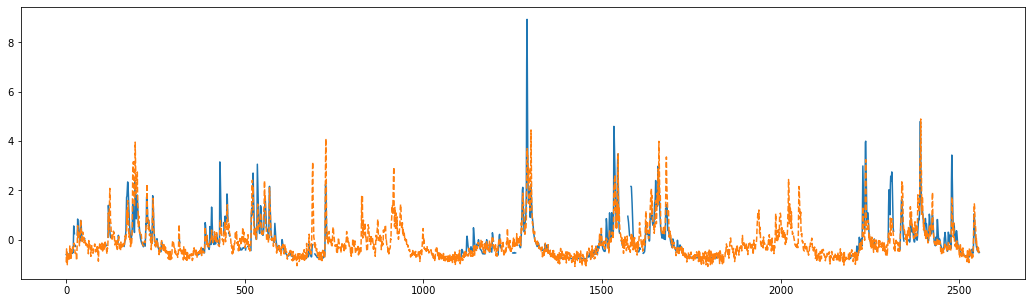

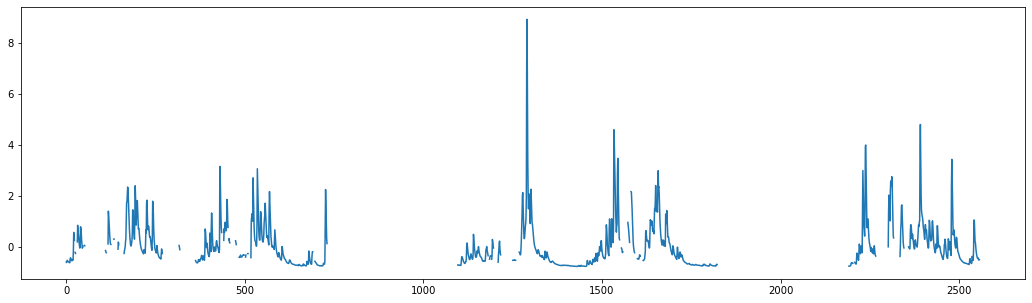

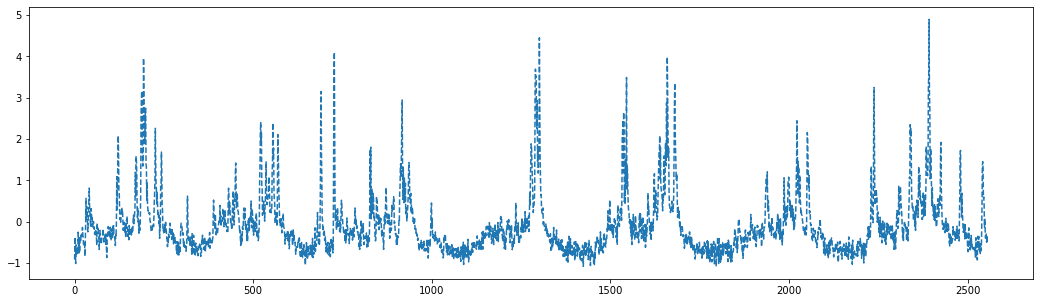

In [9]:
plt.figure(figsize=(18,5))
plt.plot(test_gt['1D'][:,0,0])
plt.plot(test_pred['1D'][:,0,0], '--')
plt.show()

plt.figure(figsize=(18,5))
plt.plot(test_gt['1D'][:,0,0])
plt.show()

plt.figure(figsize=(18,5))
plt.plot(test_pred['1D'][:,0,0], '--')
plt.show()

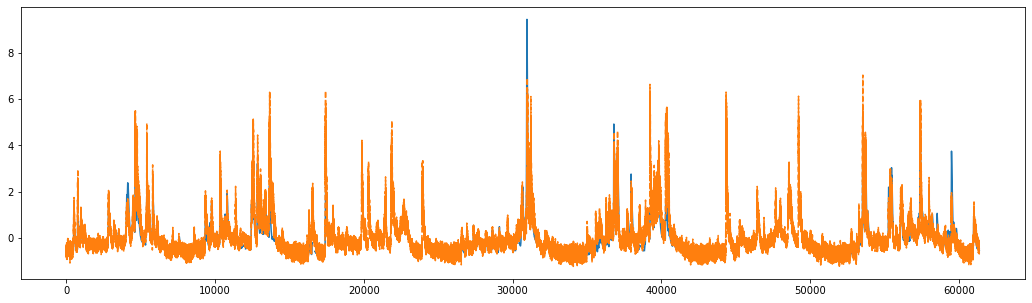

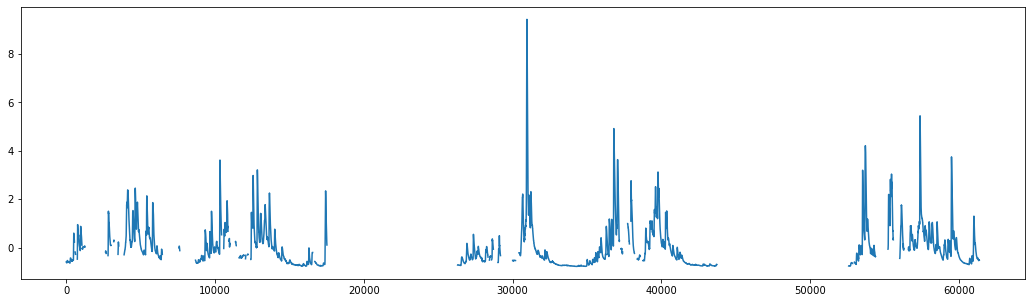

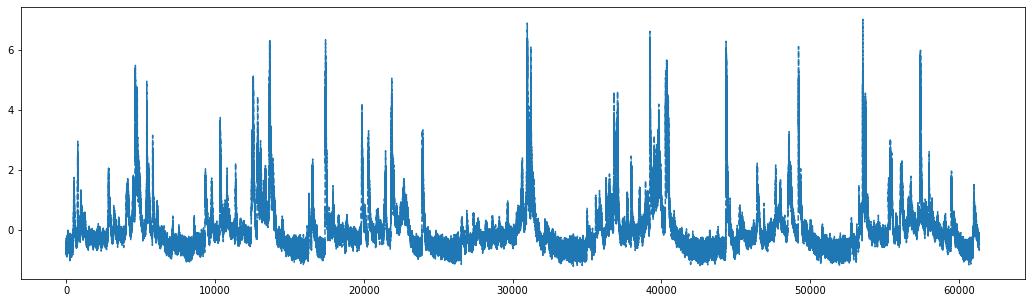

In [10]:
plt.figure(figsize=(18,5))
plt.plot(test_gt['1H'][:,:,0].flatten())
plt.plot(test_pred['1H'][:,:,0].flatten(), '--')
plt.show()

plt.figure(figsize=(18,5))
plt.plot(test_gt['1H'][:,:,0].flatten())
plt.show()

plt.figure(figsize=(18,5))
plt.plot(test_pred['1H'][:,:,0].flatten(), '--')
plt.show()
